In [0]:
!pip install ds-box

     |████████████████████████████████| 143kB 8.8MB/s 


# Classic Auto-encoders architectures
## Denoising and automatic classification of images + data generation

**Disclaimer**: examples mainly extracted from the official Keras tutorial https://blog.keras.io/building-autoencoders-in-keras.html

Notebook and DSbox lib packaged by [V. Levorato](https://www.linkedin.com/in/vlevorato/).<br/>
GitHub: https://github.com/vlevorato/dsbox


Mainly used review article: *Charte and al. A practical tutorial on autoencoders for nonlinear feature fusion: Taxonomy, models, software and guidelines, Information Fusion journal, 2018*

arxiv url: https://arxiv.org/abs/1801.01586

In [0]:
import pandas as pd

In [0]:
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

## Data import
We recover the famous MNIST dataset of handwritten figures.

In [0]:
from keras.datasets import mnist

In [0]:
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


Example of image found in the dataset:

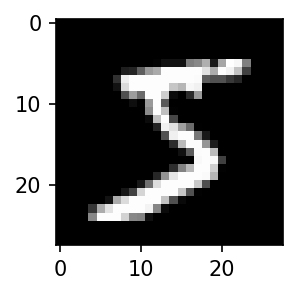

In [0]:
plt.figure(figsize=(2, 2))
plt.imshow(x_train[0], cmap=cm.gray)

Normalizing:

In [0]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Construction of AutoEncoders

In [0]:
from dsbox.ml.neural_networks.keras_factory.autoencoders import SimpleAutoEncoderFactory, DeepAutoEncoderFactory, \
AutoEncoderClassifier, CNNDenoisingAutoEncoder2DFactory, VariationalAutoEncoderFactory

The `KerasFactory` class usually returns a single model of neural networks, which is then passed as an argument to a Keras Scikit wrapper. In the case of AutoEncoders, you may need to have access to the "central" layer, so as to capture the "compressed" representation of the data. For that, all the factories of AutoEncoders of DSbox returns the global model with at least the encoder, even the decoder in certain cases.

![Autoencoder architecture](https://user-images.githubusercontent.com/17388898/81772193-80599e80-94e5-11ea-85ab-06caba2211dd.png)

To remain "skitlearn compliant", Keras has a scikit wrapper. To remain compatible with the scikit contract, since we need at least 2 models at the same time (autoencoder + encoder), an `AutoEncoderClassifier` class has been created so as to have a "skitlearn compliant" wrapper encapsulating the 2 models.

In [0]:
# small function based on the tutorial code for display
def plot_images(x_test, decoded_imgs, x_test_reshape_size=(28,28) , decoded_imgs_reshape_size=(28,28), n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):

        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(x_test_reshape_size), cmap=cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(decoded_imgs_reshape_size), cmap=cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

The size of the input data corresponds to a flat image (28 x 28 = 784).

In [0]:
image_size = x_train.shape[1]
image_size

784

### Simple AutoEncoder

In [0]:
ae_factory = SimpleAutoEncoderFactory()
autoencoder, encoder, _ = ae_factory.create_model(encoding_dim=32, input_size=image_size)
clf_keras = AutoEncoderClassifier(autoencoder, encoder)

Classic 3-layer architecture autoencoder.

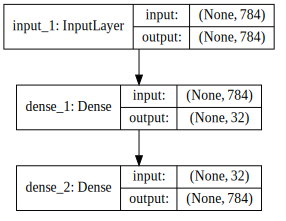

In [0]:
SVG(model_to_dot(autoencoder, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [0]:
%%time
clf_keras.fit(x_train, x_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_test, x_test))

In [0]:
decoded_imgs = clf_keras.predict(x_test)

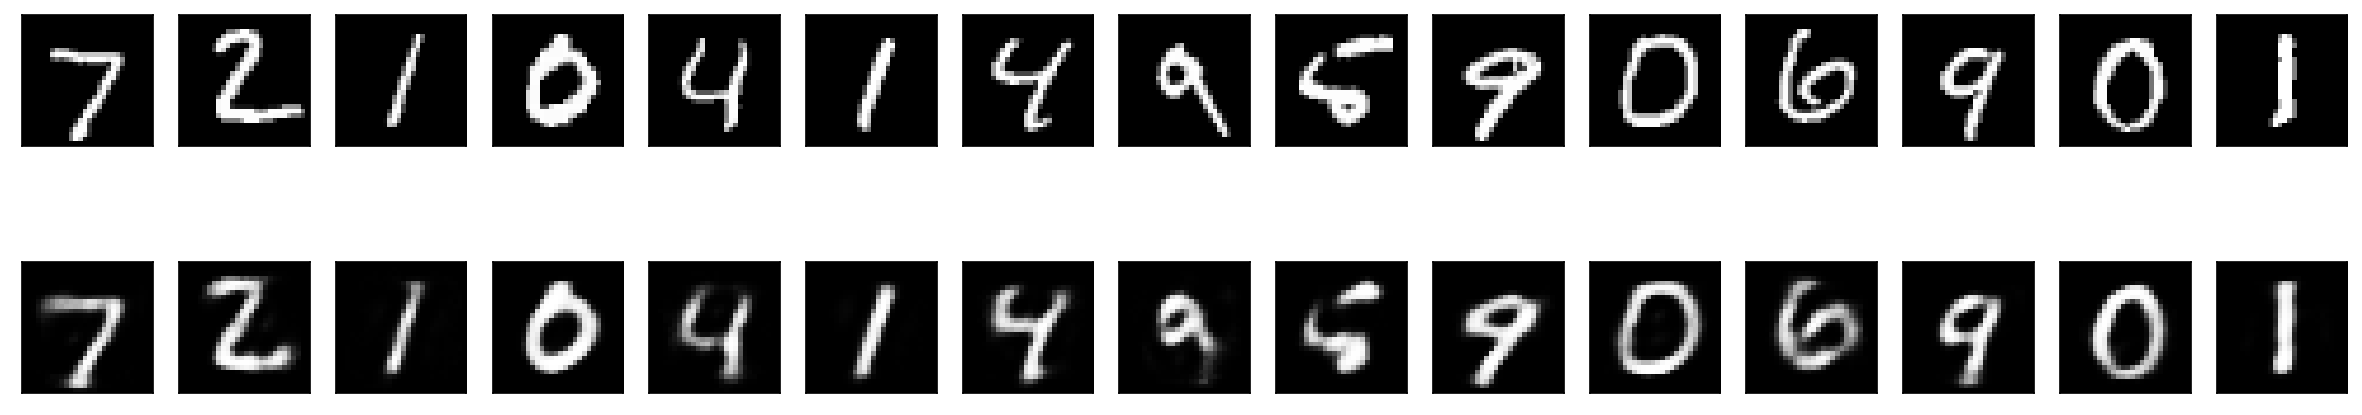

In [0]:
plot_images(x_test, decoded_imgs, n=15)

We obtain here a reconstructed representation of the test dataset, where the simple autoencoder (3 layers) simply tried to reconstruct the original image with as constraint the middle layer which compresses all the data . It can be used for denoising or for detecting outliers (what did not come out on the other side is either considered noise, or as an anomaly at choice), even if the denoising part is not necessarily extraordinary in this specific case, given the simplicity of the architecture of the AE.

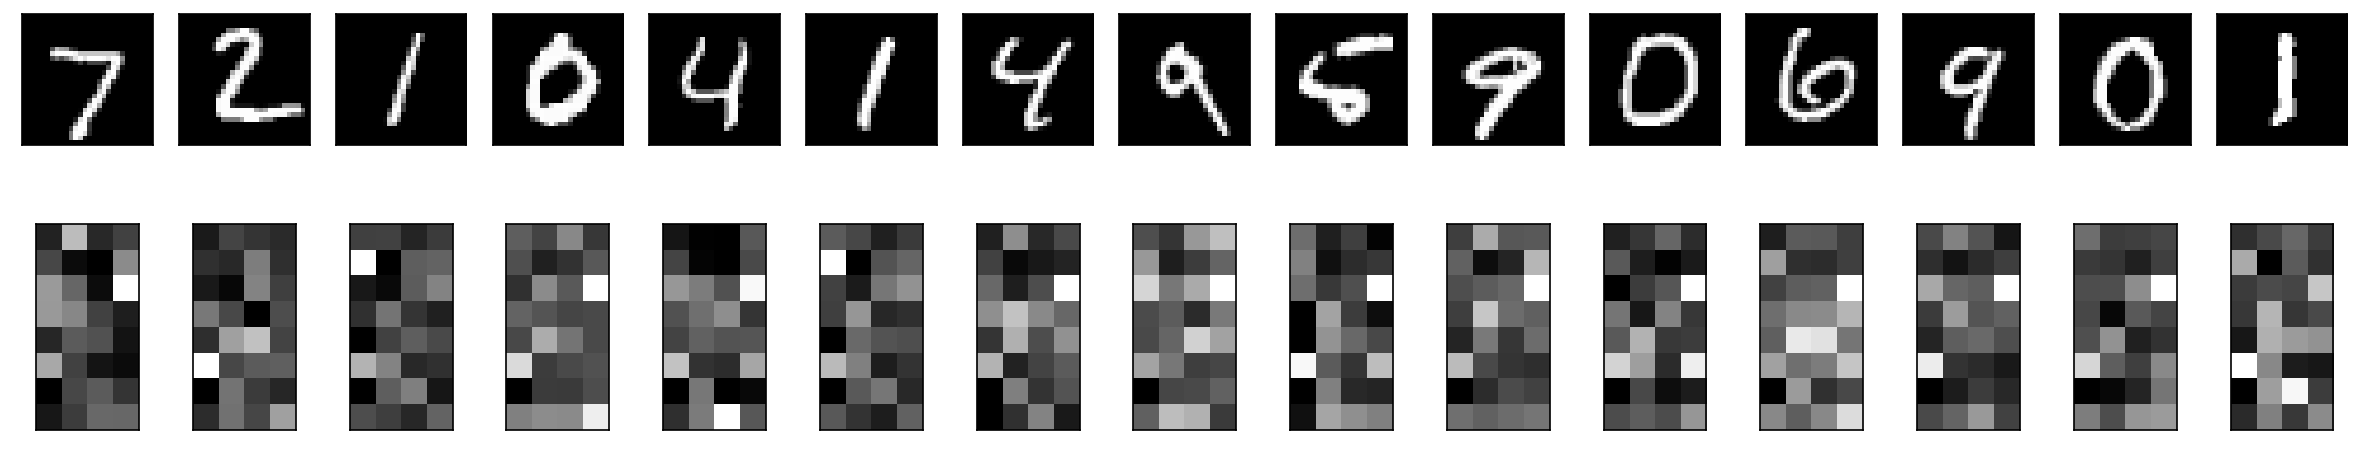

In [0]:
plot_images(x_test, clf_keras.encoded_data_, decoded_imgs_reshape_size=(8,4), n=15)

It will be interesting to take a look at the compressed part of the image (middle layer) because it is equivalent to performing a dimension reduction. In the case of a simple AE, it corresponds to a PCA. This will be the subject of a specific application with another type of autoencoder which allows non-linear dimension reductions.

### Deep AutoEncoder

In [0]:
ae_factory = DeepAutoEncoderFactory()
autoencoder, encoder = ae_factory.create_model(input_size=image_size, start_layer_size=256, sub_layers_level=4)
clf_keras = AutoEncoderClassifier(autoencoder, encoder)

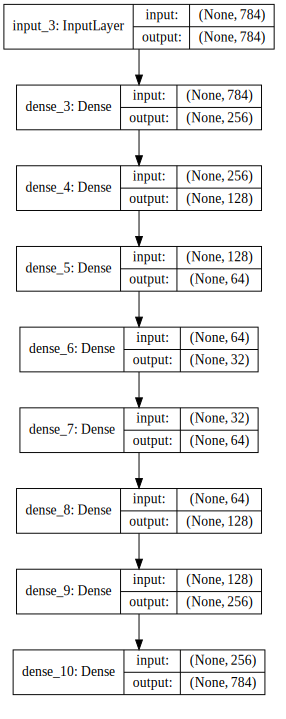

In [0]:
SVG(model_to_dot(autoencoder, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

Hourglass architecture, where we give the starting size, and the number of intermediate sublayers (size divided by 2 each time).

In [0]:
%%time
clf_keras.fit(x_train, x_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_test, x_test))

In [0]:
decoded_imgs = clf_keras.predict(x_test)

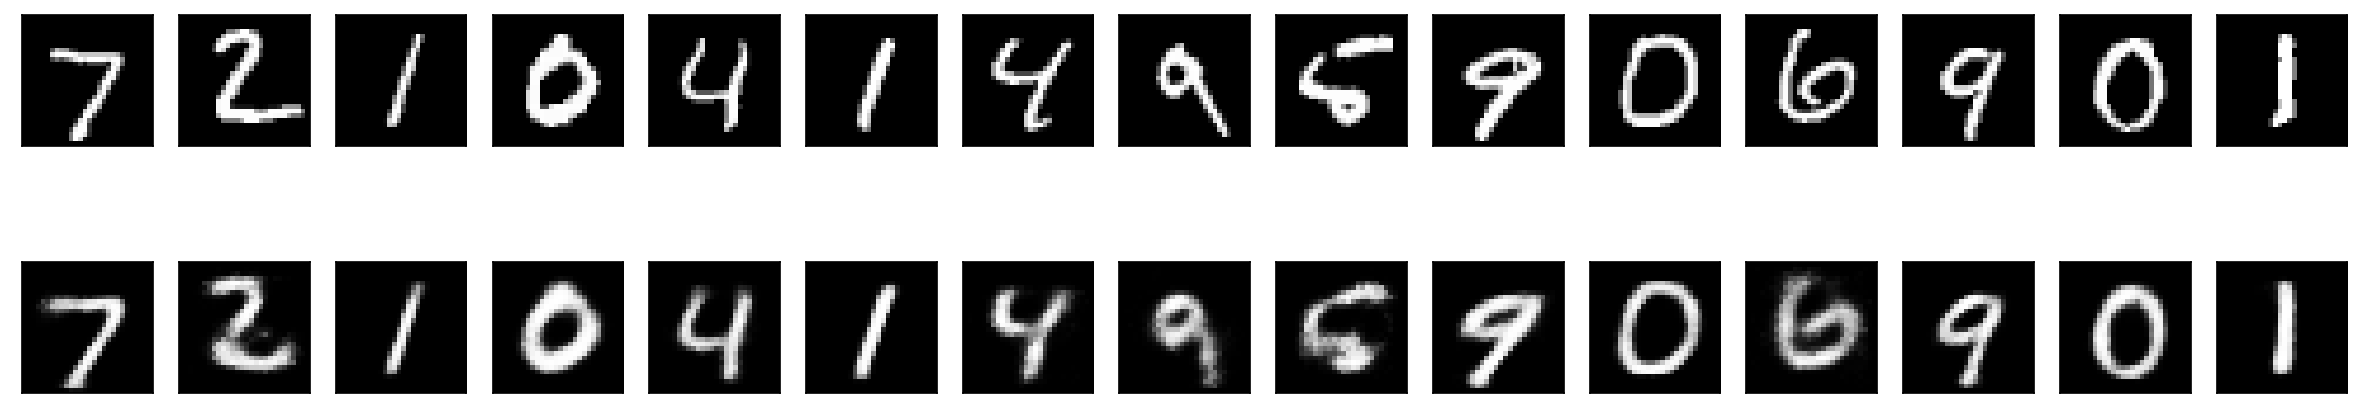

In [0]:
plot_images(x_test, decoded_imgs, n=15)

Even if the loss is almost equal to the simple AE, one has the impression that the AE is struggling to reconstruct the image. Depending on the applications, this may be desired, so that more noise will be filtered for example. In the case of handwritten numbers, the delta between the output and the input could be used to estimate the readability of the character by a human (the larger the delta, the less the number is readable).

### CNN AutoEncoder
As we go back to 2 dimensions, we reload the data:

In [0]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [0]:
ae_factory = CNNDenoisingAutoEncoder2DFactory()
autoencoder, encoder = ae_factory.create_model(shape=(28, 28, 1))
clf_keras = AutoEncoderClassifier(autoencoder, encoder)

Succession of layers of convolution and max pooling, and the same thing in the other direction, with layers upsampling instead of max pooling.

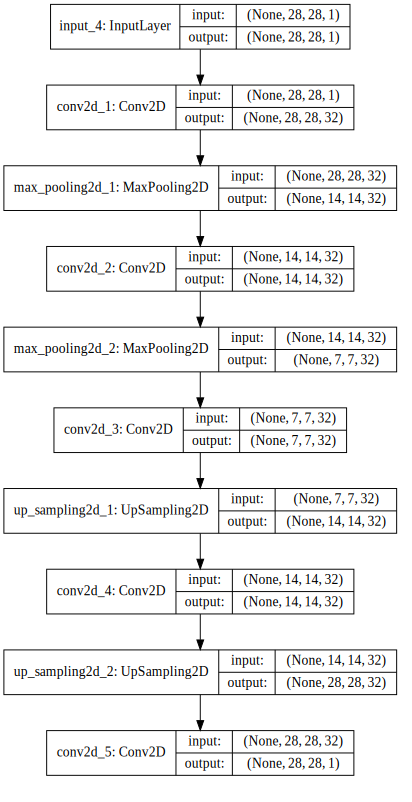

In [0]:
SVG(model_to_dot(autoencoder, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

We create noisy images, and we create a relationship between the original image and its noisy version by taking as input the noisy image and targeting the noiseless image.

In [0]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

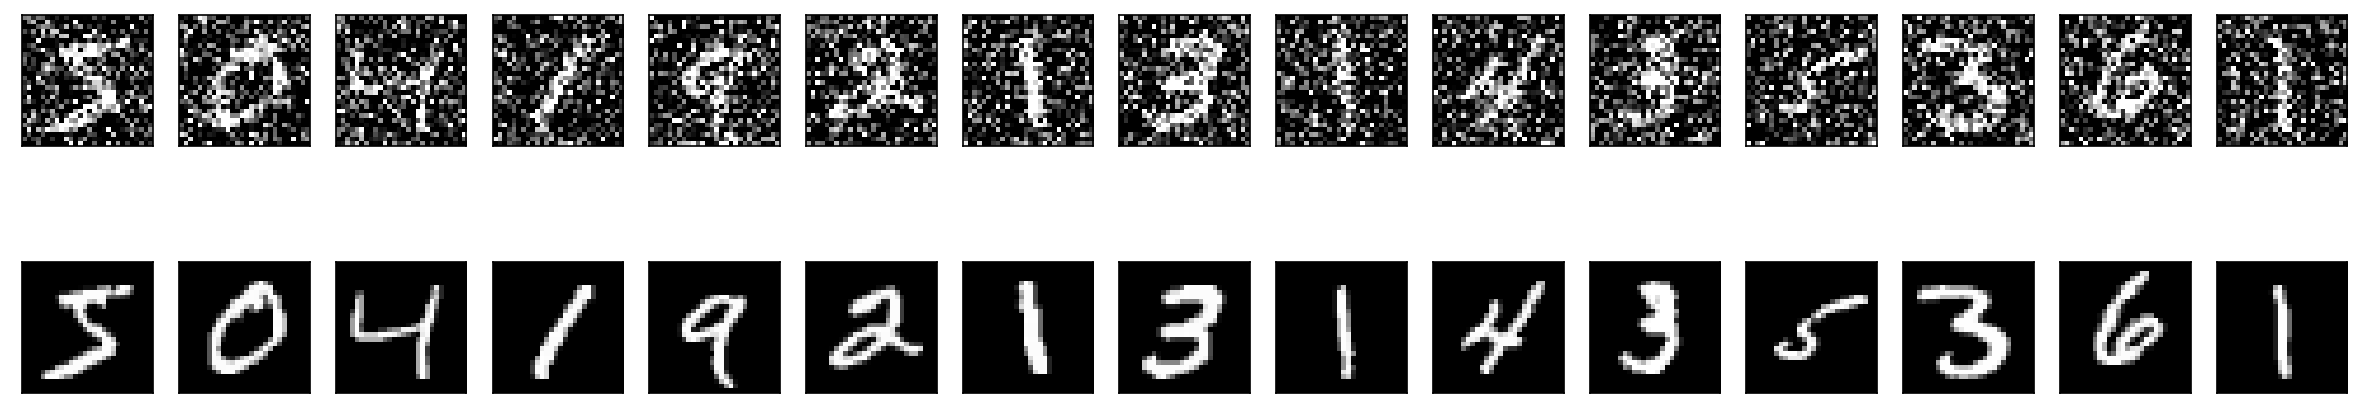

In [0]:
plot_images(x_train_noisy, x_train, n=15)

The input noisy image is given to the AE with the noiseless image as target.

In [0]:
%%time
clf_keras.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

We then look at the result if we give the AE noisy images never encountered.

In [0]:
decoded_imgs = clf_keras.predict(x_test_noisy)

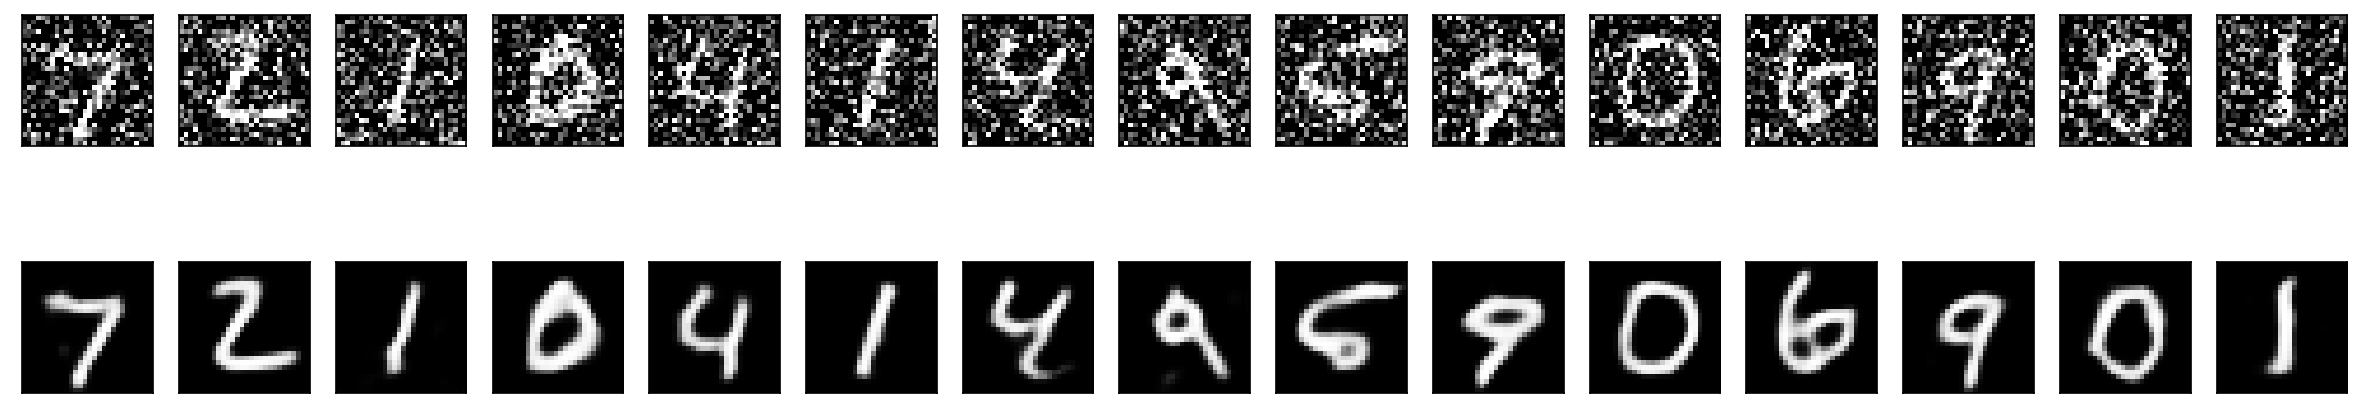

In [0]:
plot_images(x_test_noisy, decoded_imgs, n=15)

The results are pretty good overall and the AE does the job.

### Variational AutoEncoder
We reload the data properly.

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
ae_factory = VariationalAutoEncoderFactory()
autoencoder, encoder, decoder = ae_factory.create_model(input_size=784, intermediate_dim=256, latent_dim=16, epsilon_std=1.0)
clf_keras = AutoEncoderClassifier(autoencoder, encoder)

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


This type of AE use a variational Bayesian approach for encoding. We assume that there is an unobserved latent random variable $ y $ which, by a random process, leads to observations $ x $. Its objective is therefore to approximate the distribution of the latent variable from observations. Variational AEs replace the deterministic functions in the encoder and the decoder with stochastic applications, and calculate the objective function according to the density functions of the random variables of the estimated distribution (here we use the normal law).
As these models belong to the category of generative neural networks, they also allow the creation of new data.

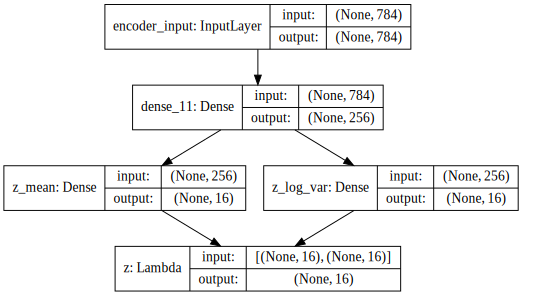

In [0]:
SVG(model_to_dot(encoder, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

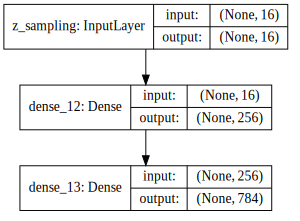

In [0]:
SVG(model_to_dot(decoder, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [0]:
%%time
clf_keras.fit(x_train, None,
                        epochs=20,
                        batch_size=128,
                        shuffle=True,
                        validation_data=(x_test, None))

#### Automatic image clustering

We take the test set and transform it into a 16-dimensional "compressed" representation. The objective is then to apply on it a non-linear dimension reduction algorithm of the manifold type. In this case, the AE helps to reduce the dimensions because the manifold type algorithms are not made to deal with very large dimensions. Here, we go from 784 dimensions to 16 dimensions, then reducing to 2 dimensions, which will allow us to display and do classic clustering. We could reduce dimensions directly to 2 by using the AE, but the results are much worse.

In [0]:
x_test_encoded = encoder.predict(x_test, batch_size=128)

We get our 10,000 test images in a 16-dimensional representation.

In [0]:
x_test_encoded[2].shape

(10000, 16)

We build a dataframe which we will use with a reduction in manifold type dimensions.

In [0]:
df_test = pd.DataFrame(x_test_encoded[2])

In [0]:
df_test.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.409775,0.814584,-0.167573,0.421137,-0.652117,1.377391,1.213723,-1.239618,-0.767023,-0.892999,-1.364710,-1.666683,-1.784041,-1.006056,0.519858,-0.321760
1,0.005074,-0.308122,0.219729,-0.822260,0.875248,0.145679,0.155565,0.244429,0.653037,-1.554318,1.955700,2.406971,0.636889,-0.424096,0.259923,-0.214310
2,-1.314678,-0.271317,0.183845,0.482864,1.645312,-0.489276,-1.234902,1.248116,0.554685,-0.211174,0.325736,0.301488,-1.690998,1.229649,-0.111297,0.523668
3,1.079609,-0.580319,-0.936748,-1.628027,-0.222681,-0.000159,-1.206574,-1.531104,0.259085,-1.319155,0.380408,-0.595314,-0.001878,1.811806,0.280067,-0.195266
4,0.724049,0.215996,0.875253,-0.097478,1.033897,1.329804,0.136220,-0.506223,-0.066481,-0.826295,-1.231744,-1.592903,1.312733,-1.285876,0.629121,-0.325626


In [0]:
from sklearn.manifold import TSNE

In [0]:
%%time
clf_man = TSNE()
test_reduc = clf_man.fit_transform(df_test)

CPU times: user 2min 38s, sys: 263 ms, total: 2min 38s
Wall time: 1min 23s


We are able to display the images in a 2-dimensional space, and we realize that with a completely automatic process, we are doing pretty well. Even if t-SNE is basically made for visualization, it also allows to separate the different images in the space.

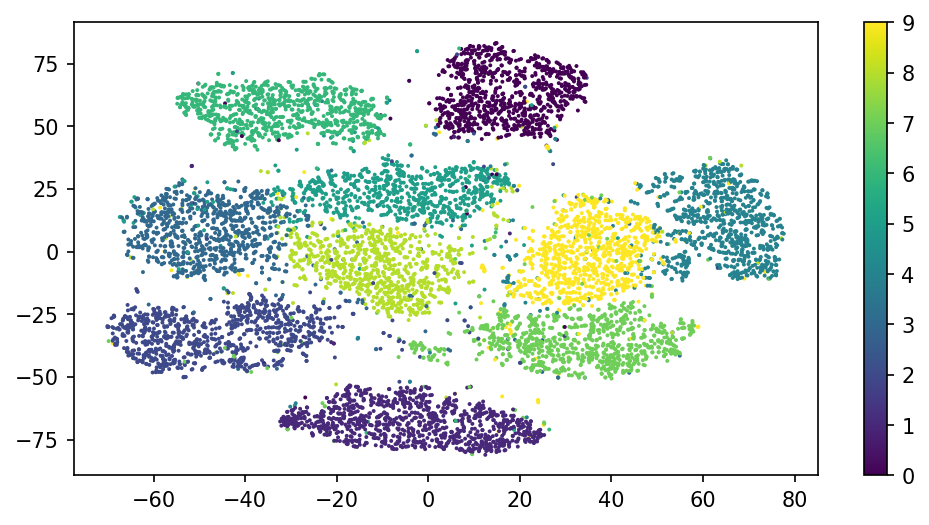

In [0]:
plt.figure(figsize=(8, 4))
plt.scatter(test_reduc[:, 0], test_reduc[:, 1], c=y_test, s=0.8)
plt.colorbar()
plt.show()

To finalize the approach, we apply a clustering algorithm to the 2-dimensional space allowing to specify the number of classes (here 10), and we then measure the result with V-Measure.

In [0]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import homogeneity_completeness_v_measure

In [0]:
clf_clust = AgglomerativeClustering(n_clusters=10)

In [0]:
clusters = clf_clust.fit_predict(test_reduc)

In [0]:
homogeneity_completeness_v_measure(labels_true=y_test,labels_pred=clusters)

(0.8384970039259126, 0.8410524792905326, 0.8397727974992802)

The V-Measure obtains around 80%, so we manage to capture around 80% of the information (of the entropy) fairly, and automatically.

#### Image generation
The particularity of the variational models of AE is that they belong to the category of generative neural networks. We can therefore have fun generating data to send to the middle layer, ask the decoder part to output a result and see what it gives.
To generate the data, it is therefore necessary to provide tables of dimension 16. We choose the normal distribution to randomly draw values since it is the latter which is estimated by the AE "a priori" (Bayesian approach). For the example, we generate 15 lines of 16 values.

In [0]:
z_sample = np.random.normal(size=(15,16))

In [0]:
x_decoded = decoder.predict(z_sample)

We display the compressed representation of size 16 randomly generated, and the result obtained below by the decoder.

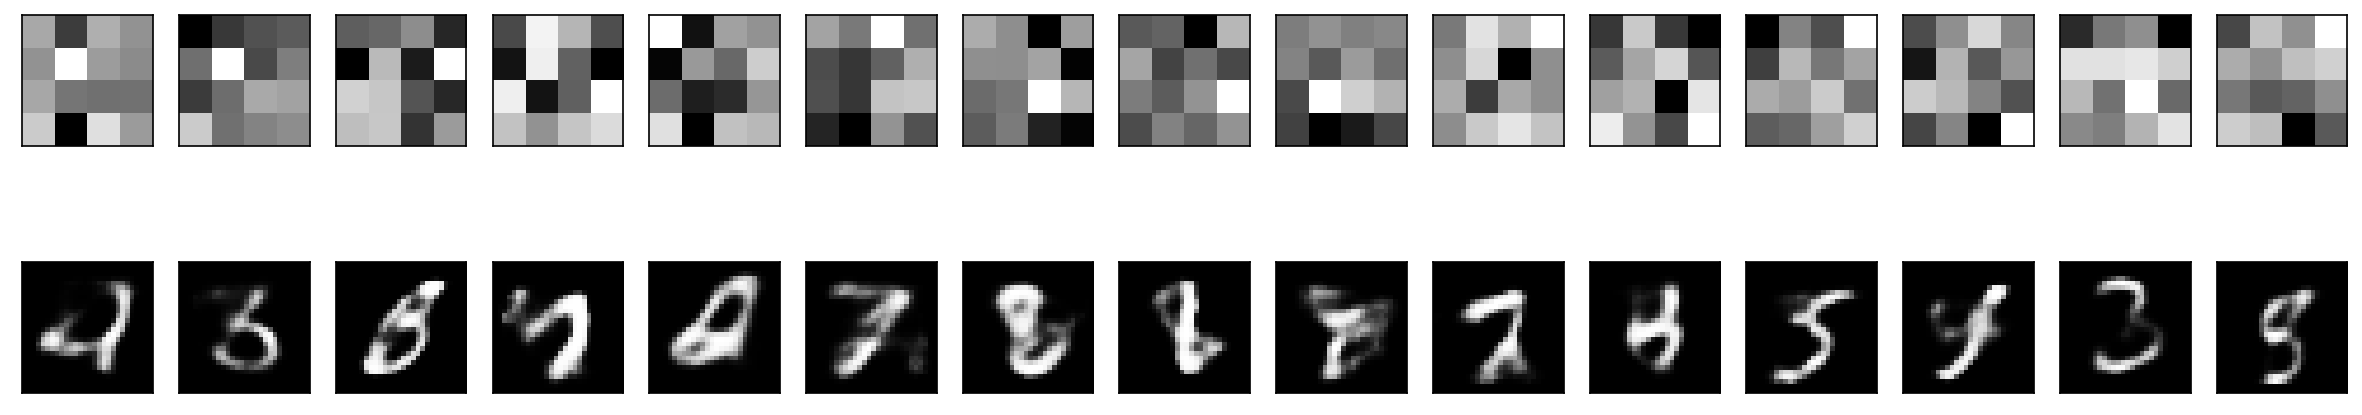

In [0]:
plot_images(z_sample, x_decoded , x_test_reshape_size=(4,4), n=15)

Sometimes the images generated do not make sense, but we are still able to create images of handwritten figures that do not look like any of those present in the original dataset.